## load packages

In [2]:
library(dplyr)
library(lubridate)
library(tableone)
library(DescTools)
library(biostat3)
library(survminer)
library(mice)
library(foreach)
library(mgcv)
library(doParallel)
library(mitools)
library(survey)
library(ipw)
library(rms)
library(tidyr)
library(EValue)
library(rpart)
library(data.table)
library(snow)
library(forestplot)
library(parglm)

In [3]:
## HR display function
OR.result.tidy <- function(result) {
    res <- result$coefficients[2, c(1, 2)]
    OR <- exp(res[1])
    lci <- exp(res[1] - qnorm(0.975) * res[2])
    uci <- exp(res[1] + qnorm(0.975) * res[2])
    res <- data.frame(OR, lci, uci)
    colnames(res) <- c('OR', 'lci', 'uci')
    res <- res %>% 
        data.frame() %>% 
        mutate_at(vars(OR, lci, uci), funs(round(., 2))) 
    res <- res %>% 
        mutate(OR = paste0(res[, 1], " (", res[, 2], "-", res[, 3], ")")) %>% 
        cbind(group = c('discontinuation')) %>% 
        dplyr::select(c(4, 1))
    res <- rbind(data.frame(group = 'reinitiation', OR = 'Ref'), res) 
    res$group <- as.character(res$group)
    return(res)
}

## import data

In [4]:
load('dta_tidied_PP.R')

In [5]:
dta_clone_CVD_death <- dta_clone %>% 
    arrange(X, lopnr, index_date) %>% 
    group_by(X, lopnr) %>% 
    mutate(death_filter = cumsum(outcome_death), 
           censor_filter = cumsum(censor), 
           CVD_death_filter = cumsum(outcome_CVD_death)) %>% 
    filter(death_filter <= 1 & censor_filter <= 1 & CVD_death_filter <= 1) %>% 
    ungroup() %>% 
    dplyr::select(c('lopnr', 'ID', 'X', 
                    'index_date', 'after_index_date', 'rank', 
                    'age', 'female', 'index_year', 'duration', 
                    'cov_diabetes_t0', 'cov_hypertension_t0', 
                    'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                    'cov_cancer_t0', 'cov_COPD_t0', 
                    'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                    'cov_statin_t0', 
                    'cov_antiplatelet_agent_t0', 
                    'cov_egfr_t0', 'cov_egfr_cat_t0', 'cov_acr_t0', 'cov_acr_cat_t0', 
                    'potassium_value', 'potassium_cat', 
                    'cov_hospitalization_t0', 
                    'primary_care_num', 'outpatient_num', 'inpatient_num', 
                    'cov_diabetes', 'cov_hypertension', 
                    'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                    'cov_cancer', 'cov_COPD',  
                    'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                    'cov_statin', 
                    'cov_antiplatelet_agent', 
                    'cov_egfr', 'cov_egfr_cat', 'cov_acr', 'cov_acr_cat', 
                    'cov_potassium', 'cov_hospitalization', 
                    'outcome_CVD_death', 'censor', 'treatment'))

## description of chracteristics at month 6 (unweighted)

In [6]:
dta_clone_CVD_death_6_month <- dta_clone_CVD_death %>% filter(rank == 6)

In [7]:
xvars <- c('age', 'female', 'index_year', 'duration', 'potassium_cat', 
           'cov_diabetes', 'cov_hypertension', 
           'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
           'cov_cancer', 'cov_COPD',  
           'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
           'cov_statin', 
           'cov_antiplatelet_agent', 
           # 'cov_potassium', 
           'cov_egfr_cat', 
           'primary_care_num', 'cov_hospitalization', 'outpatient_num', 'inpatient_num')
xfactorvars <- c('female', 'index_year', 'potassium_cat', 
                 'cov_diabetes', 'cov_hypertension', 
                 'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                 'cov_cancer', 'cov_COPD',  
                 'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                 'cov_statin', 
                 'cov_antiplatelet_agent', 
                 'cov_egfr_cat', 'cov_hospitalization')
xnonnormvars <- c('duration', # 'cov_potassium', 
                  'primary_care_num', 'outpatient_num', 'inpatient_num')

In [8]:
tb1.part <- CreateTableOne(xvars, strata = 'X', data = dta_clone_CVD_death_6_month, factorVars = xfactorvars, includeNA = T)
tb1.part <- print(tb1.part, nonnormal = xnonnormvars, test = F, smd = T, printToggle = F)

In [9]:
dta_clone_CVD_death_imp1 <- dta_clone_CVD_death

## description of CVD_death event in each arm (unweighted)

In [10]:
source('results function.R')
dta_clone_CVD_death_imp1_fixed <- dta_clone_CVD_death_imp1 %>% 
        arrange(ID, index_date) %>% 
        group_by(ID) %>% 
        summarise(index_date = min(index_date), 
                  after_index_date = max(after_index_date), 
                  outcome_CVD_death = sum(outcome_CVD_death), 
                  X = first(X))
incid_num('outcome_CVD_death', 'index_date', 'after_index_date', 'X', 
          dta_clone_CVD_death_imp1_fixed, digit = 2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


group,n,followup,event,person_years,incidence rate
<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
discontinuation,5669,0.16 [0.08-0.33],253,2206.64,0.11 (0.1-0.13)
reinitiation,5669,0.58 [0.49-1.25],245,5299.82,0.05 (0.04-0.05)


## IPW calculation

In [11]:
x_adjusted_var <- c('age', 'female', 'index_year', 'rcs(duration, 3)', 'rcs(potassium_value, 3)', 
                    # 'cov_diabetes_t0', 'cov_hypertension_t0', 
                    # 'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                    # 'cov_COPD_t0', 
                    # 'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                    # 'cov_statin_t0', 
                    # 'cov_antiplatelet_agent_t0', 
                    # 'cov_egfr_t0', 
                    'primary_care_num', 
                    'outpatient_num', 
                    'inpatient_num', # 'cov_hospitalization_t0', 
                    'cov_diabetes', 'cov_hypertension', 
                    'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                    'cov_cancer', 'cov_COPD',  
                    'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                    'cov_statin', 
                    'cov_antiplatelet_agent', 
                    'rcs(cov_egfr, 6)', 
                    # 'rcs(cov_potassium, 12)', 
                    'cov_hospitalization')

In [12]:
x_adjusted_var_ML <- c('age', 'female', 'index_year', 'duration', 'potassium_value', 
                       # 'cov_diabetes_t0', 'cov_hypertension_t0', 
                       # 'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                       # 'cov_COPD_t0', 
                       # 'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                       # 'cov_statin_t0', 
                       # 'cov_antiplatelet_agent_t0', 
                       # 'cov_egfr_t0', 
                       'primary_care_num', 
                       'outpatient_num', 
                       'inpatient_num', # 'cov_hospitalization_t0', 
                       'cov_diabetes', 'cov_hypertension', 
                       'cov_MI', 'cov_CHF', 'cov_cerebrovascular_disease', 'cov_PVD', 
                       'cov_cancer', 'cov_COPD',  
                       'cov_beta_blocker', 'cov_CCB', 'cov_diuretic', 'cov_MRA', 'cov_SPS', 
                       'cov_statin', 
                       'cov_antiplatelet_agent', 
                       'cov_egfr', 
                       # 'cov_potassium',
                       'cov_hospitalization')

In [13]:
dta_clone_CVD_death_imp1_discontinuation <- dta_clone_CVD_death_imp1 %>% 
    filter(X == 'discontinuation') %>% 
    arrange(ID, index_date)
dta_clone_CVD_death_imp1_discontinuation_censor_part <- dta_clone_CVD_death_imp1_discontinuation
dta_clone_CVD_death_imp1_discontinuation_noncensor_part <- dta_clone_CVD_death_imp1_discontinuation %>% 
    filter(rank == 0)

In [14]:
## logistic regression formula
regression_formula_IPCW <- as.formula(paste0('censor ~ rank + rank ^ 2 + ', 
                                             paste(x_adjusted_var, collapse = " + "), 
                                             sep = ' '))
denominator.fit <- glm(regression_formula_IPCW, 
                       data = dta_clone_CVD_death_imp1_discontinuation_censor_part, 
                       family  = binomial(link = "logit"))
numerator.fit <- glm(censor ~ rank + rank ^ 2 + age + female + index_year + duration + potassium_value + 
                     primary_care_num + outpatient_num + inpatient_num + 
                     cov_diabetes_t0 + cov_hypertension_t0 + 
                     cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                     cov_cancer_t0 + cov_COPD_t0 + 
                     cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                     cov_MRA_t0 + cov_SPS_t0 + 
                     cov_statin_t0 + 
                     cov_antiplatelet_agent_t0 + 
                     cov_egfr_t0 + 
                     cov_hospitalization_t0, 
                     data = dta_clone_CVD_death_imp1_discontinuation_censor_part, 
                     family  = binomial(link = "logit"))
## machine learning formula
ML_formula_IPCW <- as.formula(paste0('censor ~ rank + ', 
                                     paste(x_adjusted_var_ML, collapse = " + "), 
                                     sep = ' '))
denominator.fit_ML <- rpart(ML_formula_IPCW, 
                         data = dta_clone_CVD_death_imp1_discontinuation_censor_part, 
                         method = 'class')
numerator.fit_ML <- rpart(censor ~ rank + age + female + index_year + duration + potassium_value + 
                          primary_care_num + outpatient_num + inpatient_num + 
                          cov_diabetes_t0 + cov_hypertension_t0 + 
                          cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                          cov_cancer_t0 + cov_COPD_t0 + 
                          cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                          cov_MRA_t0 + cov_SPS_t0 + 
                          cov_statin_t0 + 
                          cov_antiplatelet_agent_t0 + 
                          cov_egfr_t0 + 
                          cov_hospitalization_t0,
                          data = dta_clone_CVD_death_imp1_discontinuation_censor_part, 
                          method = 'class')
## =============================================================================================================

In [15]:
## Stabilized IPW
dta_clone_CVD_death_imp1_discontinuation_censor_part$ipw_per_month <- 
    ifelse(dta_clone_CVD_death_imp1_discontinuation_censor_part$censor == 1, 
           0, 
           (1 - fitted(numerator.fit)) / (1 - fitted(denominator.fit)))
dta_clone_CVD_death_imp1_discontinuation_noncensor_part$ipw_per_month <- 1
## =============================================================================================================
## Unstabilized IPW
dta_clone_CVD_death_imp1_discontinuation_censor_part$ipw_uns_per_month <- 
    ifelse(dta_clone_CVD_death_imp1_discontinuation_censor_part$censor == 1, 
           0, 
           1 / (1 - fitted(denominator.fit)))
dta_clone_CVD_death_imp1_discontinuation_noncensor_part$ipw_uns_per_month <- 1
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_CVD_death_imp1_discontinuation_censor_part$ipw_ML_per_month <- 
    ifelse(dta_clone_CVD_death_imp1_discontinuation_censor_part$censor == 1, 
           0, 
           predict(numerator.fit_ML)[, 1] / predict(denominator.fit_ML)[, 1])
dta_clone_CVD_death_imp1_discontinuation_noncensor_part$ipw_ML_per_month <- 1
## =============================================================================================================

In [16]:
dta_clone_CVD_death_imp1_discontinuation <- rbind(dta_clone_CVD_death_imp1_discontinuation_censor_part, 
                                              dta_clone_CVD_death_imp1_discontinuation_noncensor_part) %>% 
    arrange(ID, index_date)
## Stabilized IPW
dta_clone_CVD_death_imp1_discontinuation$ipw <- unlist(tapply(dta_clone_CVD_death_imp1_discontinuation$ipw_per_month, 
                                                         dta_clone_CVD_death_imp1_discontinuation$ID, cumprod))
## =============================================================================================================
## Unstabilized IPW
dta_clone_CVD_death_imp1_discontinuation$ipw_uns <- unlist(tapply(dta_clone_CVD_death_imp1_discontinuation$ipw_uns_per_month, 
                                                              dta_clone_CVD_death_imp1_discontinuation$ID, cumprod))
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_CVD_death_imp1_discontinuation$ipw_ML <- unlist(tapply(dta_clone_CVD_death_imp1_discontinuation$ipw_ML_per_month, 
                                                             dta_clone_CVD_death_imp1_discontinuation$ID, cumprod))
## =============================================================================================================

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.7557  0.9622  0.8461  1.0656  3.4701 

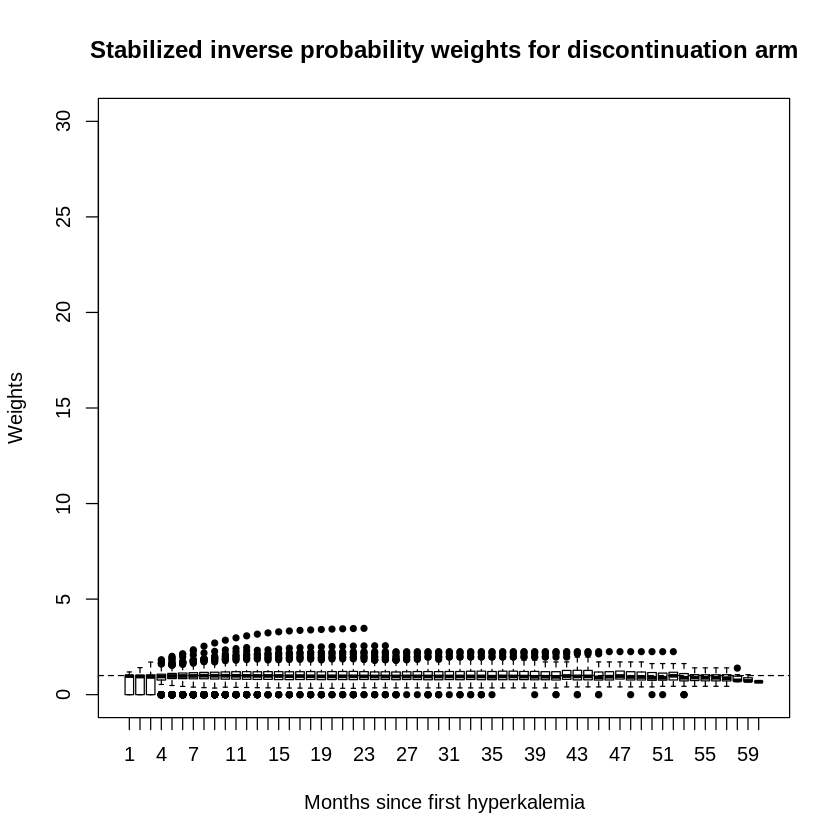

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.497   3.024   5.418   6.593  77.087 

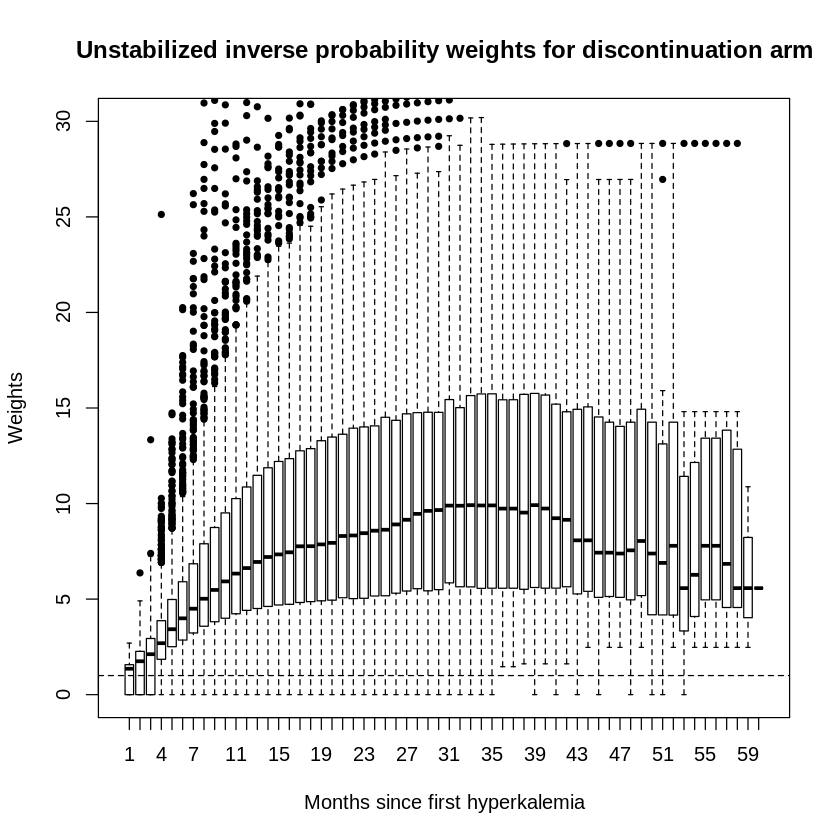

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.8319  1.0000  1.0000 

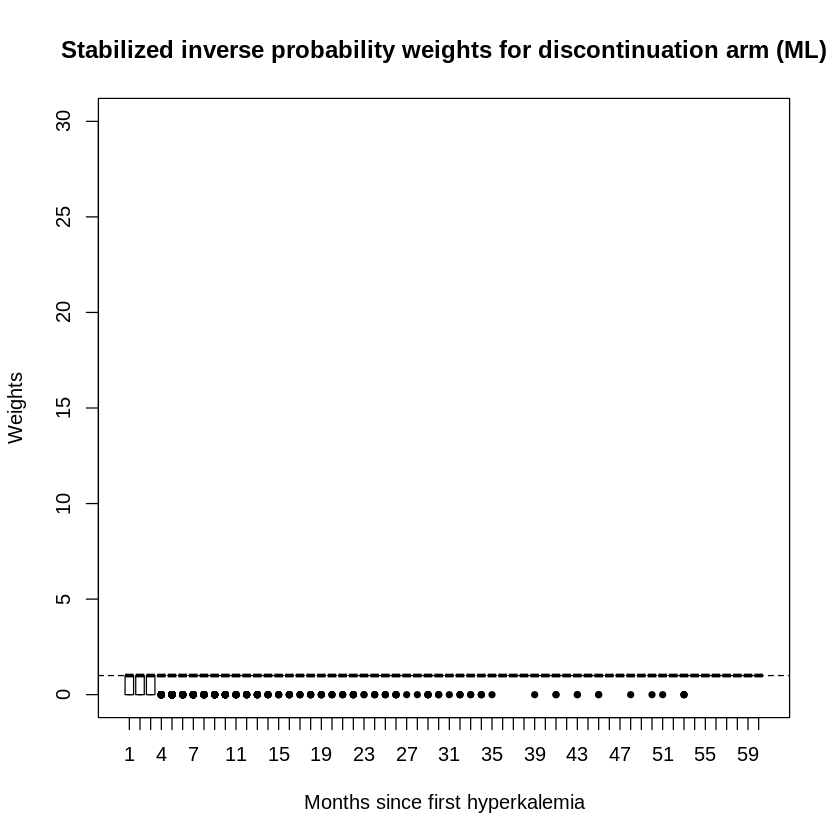

In [17]:
ipwplot(dta_clone_CVD_death_imp1_discontinuation$ipw, dta_clone_CVD_death_imp1_discontinuation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for discontinuation arm', 
        ylim = c(0, 30))
summary(dta_clone_CVD_death_imp1_discontinuation$ipw)
ipwplot(dta_clone_CVD_death_imp1_discontinuation$ipw_uns, dta_clone_CVD_death_imp1_discontinuation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Unstabilized inverse probability weights for discontinuation arm', 
        ylim = c(0, 30))
summary(dta_clone_CVD_death_imp1_discontinuation$ipw_uns)
ipwplot(dta_clone_CVD_death_imp1_discontinuation$ipw_ML, dta_clone_CVD_death_imp1_discontinuation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for discontinuation arm (ML)', 
        ylim = c(0, 30))
summary(dta_clone_CVD_death_imp1_discontinuation$ipw_ML)

In [18]:
dta_clone_CVD_death_imp1_reinitiation <- dta_clone_CVD_death_imp1 %>% 
    filter(X == 'reinitiation') %>% 
    arrange(ID, index_date)
dta_clone_CVD_death_imp1_reinitiation_censor_part <- dta_clone_CVD_death_imp1_reinitiation %>% 
    filter(rank >= 2)
dta_clone_CVD_death_imp1_reinitiation_noncensor_part <- dta_clone_CVD_death_imp1_reinitiation %>% 
    filter(rank == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.9514  0.9943  0.9449  1.0122  4.3731 

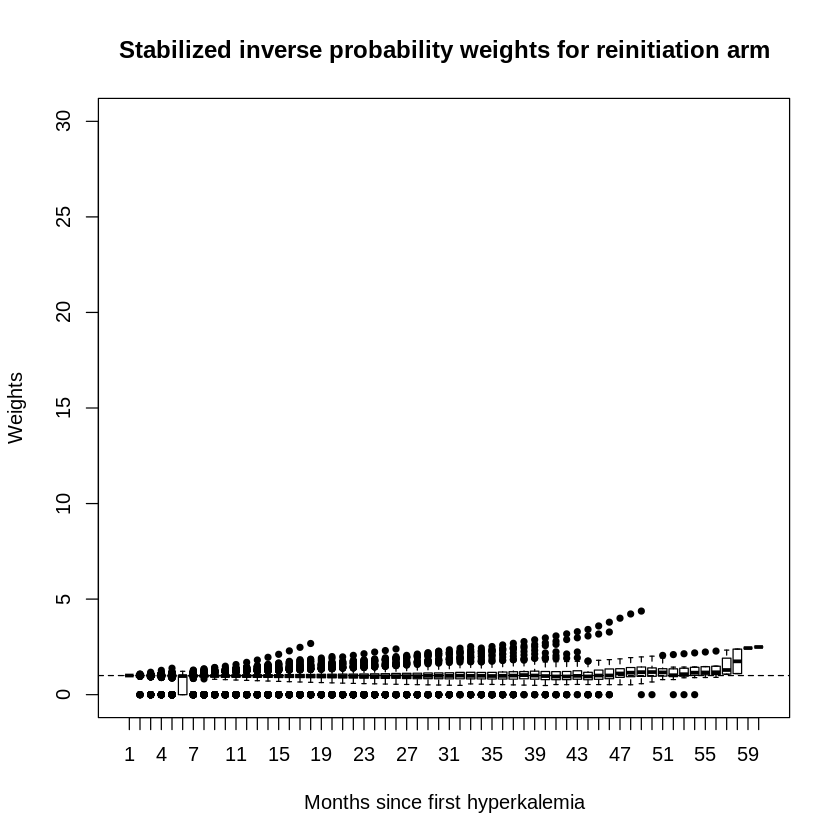

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.106   1.378   2.180   2.125 526.068 

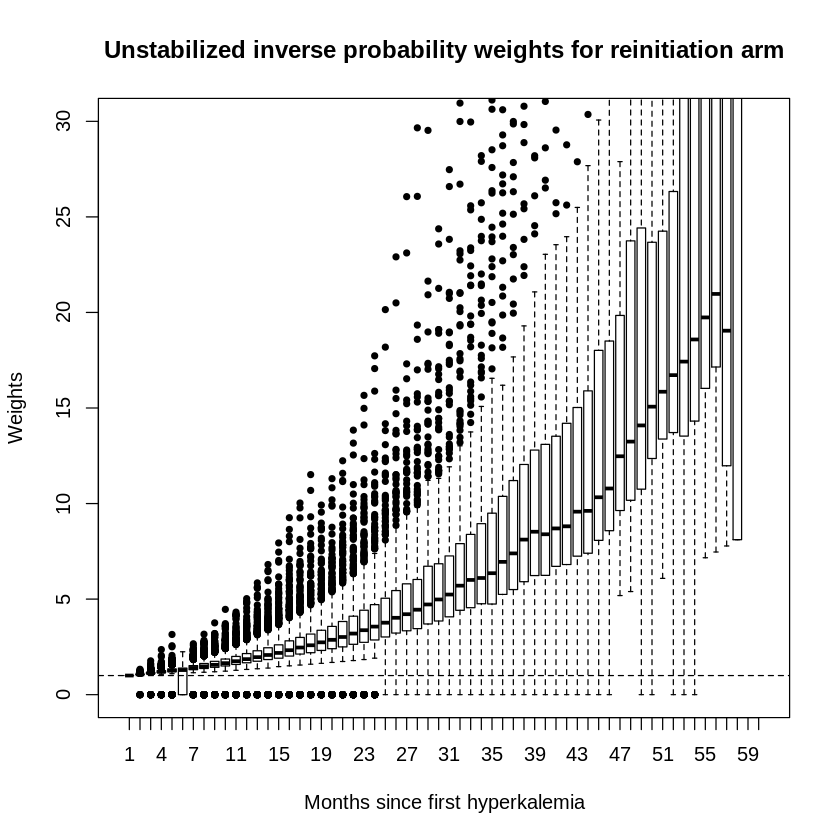

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9443  1.0000  1.0000 

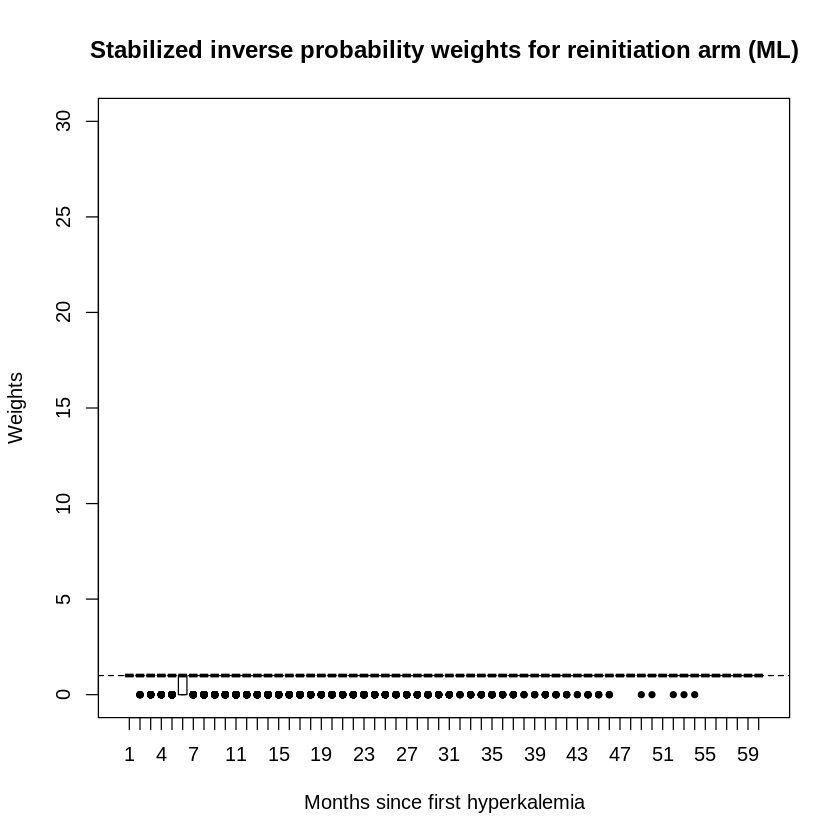

In [19]:
regression_formula_IPCW <- as.formula(paste0('censor ~ rank + rank ^ 2 + ', 
                                             paste(x_adjusted_var, collapse = " + "), 
                                             sep = ' '))
denominator.fit <- glm(regression_formula_IPCW, 
                       data = dta_clone_CVD_death_imp1_reinitiation_censor_part, 
                       family  = binomial(link = "logit"))
numerator.fit <- glm(censor ~ age + female + index_year + duration + potassium_value + 
                     primary_care_num + outpatient_num + inpatient_num + 
                     cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                     cov_cancer_t0 + cov_COPD_t0 + 
                     cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                     cov_MRA_t0 + cov_SPS_t0 + 
                     cov_statin_t0 + 
                     cov_antiplatelet_agent_t0 + 
                     cov_egfr_t0 + 
                     cov_hospitalization_t0, , 
                     data = dta_clone_CVD_death_imp1_reinitiation_censor_part, 
                     family  = binomial(link = "logit"))
## machine learning formula
ML_formula_IPCW <- as.formula(paste0('censor ~ rank + ', 
                                     paste(x_adjusted_var_ML, collapse = " + "), 
                                     sep = ' '))
denominator.fit_ML <- rpart(ML_formula_IPCW, 
                         data = dta_clone_CVD_death_imp1_reinitiation_censor_part, 
                         method = 'class')
numerator.fit_ML <- rpart(censor ~ age + female + index_year + duration + potassium_value  + 
                          primary_care_num + outpatient_num + inpatient_num + 
                          cov_diabetes_t0 + cov_hypertension_t0 + 
                          cov_MI_t0 + cov_CHF_t0 + cov_cerebrovascular_disease_t0 + cov_PVD_t0 + 
                          cov_cancer_t0 + cov_COPD_t0 + 
                          cov_beta_blocker_t0 + cov_CCB_t0 + cov_diuretic_t0 + 
                          cov_MRA_t0 + cov_SPS_t0 + 
                          cov_statin_t0 + 
                          cov_antiplatelet_agent_t0 + 
                          cov_egfr_t0 + 
                          cov_hospitalization_t0, 
                          data = dta_clone_CVD_death_imp1_reinitiation_censor_part, 
                          method = 'class')
## =============================================================================================================
## Stabilized IPW
dta_clone_CVD_death_imp1_reinitiation_censor_part$ipw_per_month <- 
    ifelse(dta_clone_CVD_death_imp1_reinitiation_censor_part$censor == 1, 
           0, 
           (1 - fitted(numerator.fit)) / (1 - fitted(denominator.fit)))
dta_clone_CVD_death_imp1_reinitiation_noncensor_part$ipw_per_month <- 1
## =============================================================================================================
## Unstabilized IPW
dta_clone_CVD_death_imp1_reinitiation_censor_part$ipw_uns_per_month <- 
    ifelse(dta_clone_CVD_death_imp1_reinitiation_censor_part$censor == 1, 
           0, 
           1 / (1 - fitted(denominator.fit)))
dta_clone_CVD_death_imp1_reinitiation_noncensor_part$ipw_uns_per_month <- 1
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_CVD_death_imp1_reinitiation_censor_part$ipw_ML_per_month <- 
    ifelse(dta_clone_CVD_death_imp1_reinitiation_censor_part$censor == 1, 
           0, 
           predict(numerator.fit_ML)[, 1] / predict(denominator.fit_ML)[, 1])
dta_clone_CVD_death_imp1_reinitiation_noncensor_part$ipw_ML_per_month <- 1
## =============================================================================================================
dta_clone_CVD_death_imp1_reinitiation <- rbind(dta_clone_CVD_death_imp1_reinitiation_censor_part, 
                                           dta_clone_CVD_death_imp1_reinitiation_noncensor_part) %>% 
    arrange(ID, index_date)
## Stabilized IPW
dta_clone_CVD_death_imp1_reinitiation$ipw <- unlist(tapply(dta_clone_CVD_death_imp1_reinitiation$ipw_per_month, 
                                                       dta_clone_CVD_death_imp1_reinitiation$ID, cumprod))
## =============================================================================================================
## Unstabilized IPW
dta_clone_CVD_death_imp1_reinitiation$ipw_uns <- unlist(tapply(dta_clone_CVD_death_imp1_reinitiation$ipw_uns_per_month, 
                                                           dta_clone_CVD_death_imp1_reinitiation$ID, cumprod))
## =============================================================================================================
## Stabilized IPW by ML
dta_clone_CVD_death_imp1_reinitiation$ipw_ML <- unlist(tapply(dta_clone_CVD_death_imp1_reinitiation$ipw_ML_per_month, 
                                                          dta_clone_CVD_death_imp1_reinitiation$ID, cumprod))
## =============================================================================================================
ipwplot(dta_clone_CVD_death_imp1_reinitiation$ipw, dta_clone_CVD_death_imp1_reinitiation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for reinitiation arm', 
        ylim = c(0, 30))
summary(dta_clone_CVD_death_imp1_reinitiation$ipw)
ipwplot(dta_clone_CVD_death_imp1_reinitiation$ipw_uns, dta_clone_CVD_death_imp1_reinitiation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Unstabilized inverse probability weights for reinitiation arm', 
        ylim = c(0, 30))
summary(dta_clone_CVD_death_imp1_reinitiation$ipw_uns)
ipwplot(dta_clone_CVD_death_imp1_reinitiation$ipw_ML, dta_clone_CVD_death_imp1_reinitiation$rank, 
        binwidth = 1, logscale = F, 
        xlab = 'Months since first hyperkalemia', 
        ylab = 'Weights', 
        main = 'Stabilized inverse probability weights for reinitiation arm (ML)', 
        ylim = c(0, 30))
summary(dta_clone_CVD_death_imp1_reinitiation$ipw_ML)

In [20]:
## truncate unstabilized weight at 10
ipw.truncation <- function(ipw.weights, trunc.u = 10, trunc.l = 0) {
    weights.trunc.temp <- ifelse(ipw.weights >= trunc.u, trunc.u, ipw.weights) 
    weights.trunc <- ifelse(weights.trunc.temp <= trunc.l, trunc.l, weights.trunc.temp) 
}
dta_clone_CVD_death_imp1_discontinuation$ipw_uns_trunc <- 
    ipw.truncation(dta_clone_CVD_death_imp1_discontinuation$ipw_uns,
                   trunc.u = quantile(dta_clone_CVD_death_imp1_discontinuation$ipw_uns, 0.99))
dta_clone_CVD_death_imp1_reinitiation$ipw_uns_trunc <- 
    ipw.truncation(dta_clone_CVD_death_imp1_reinitiation$ipw_uns,
                   trunc.u = quantile(dta_clone_CVD_death_imp1_reinitiation$ipw_uns, 0.99))
dta_clone_CVD_death_imp1 <- rbind(dta_clone_CVD_death_imp1_discontinuation, dta_clone_CVD_death_imp1_reinitiation) %>% 
    arrange(ID, index_date)

## description of chracteristics at month 6 and CVD_death event in each arm (weighted)

In [21]:
dta_clone_CVD_death_6_month_weighted <- dta_clone_CVD_death %>% 
    left_join(dta_clone_CVD_death_imp1[ , c('ID', 'rank', 'ipw_uns_trunc')], by = c('ID', 'rank')) %>% 
    filter(rank == 6)

In [22]:
dta_clone_CVD_death_6_month_weighted <- svydesign(ids = ~ ID, 
                                              data = dta_clone_CVD_death_6_month_weighted, 
                                              weights = ~ dta_clone_CVD_death_6_month_weighted$ipw_uns_trunc)

In [23]:
tb1.part_weighted <- svyCreateTableOne(xvars, strata = 'X', data = dta_clone_CVD_death_6_month_weighted, factorVars = xfactorvars, includeNA = T)
tb1.part_weighted <- print(tb1.part_weighted, nonnormal = xnonnormvars, test = F, smd = T, printToggle = F)

In [24]:
tb1 <- cbind(tb1.part, tb1.part_weighted)

In [25]:
tb1_SMD_summary <- tb1[ , c(3, 6)] %>% data.frame() %>% filter(SMD != '') %>% 
    mutate(SMD = as.numeric(as.character(SMD)), 
           SMD.1 = as.numeric(ifelse(as.character(SMD.1) == '<0.001', '0.001', as.character(SMD.1)))) %>% 
    mutate(covariates = str_replace(
        str_replace(
            str_replace(
                str_replace_all(xvars, '_', ' '), 
                'cov ', ''), 
            'cat', 'categories'), 
        'num', 'number within 1 year prior')) %>% 
    mutate(covariates = factor(covariates, levels = rev(covariates)))

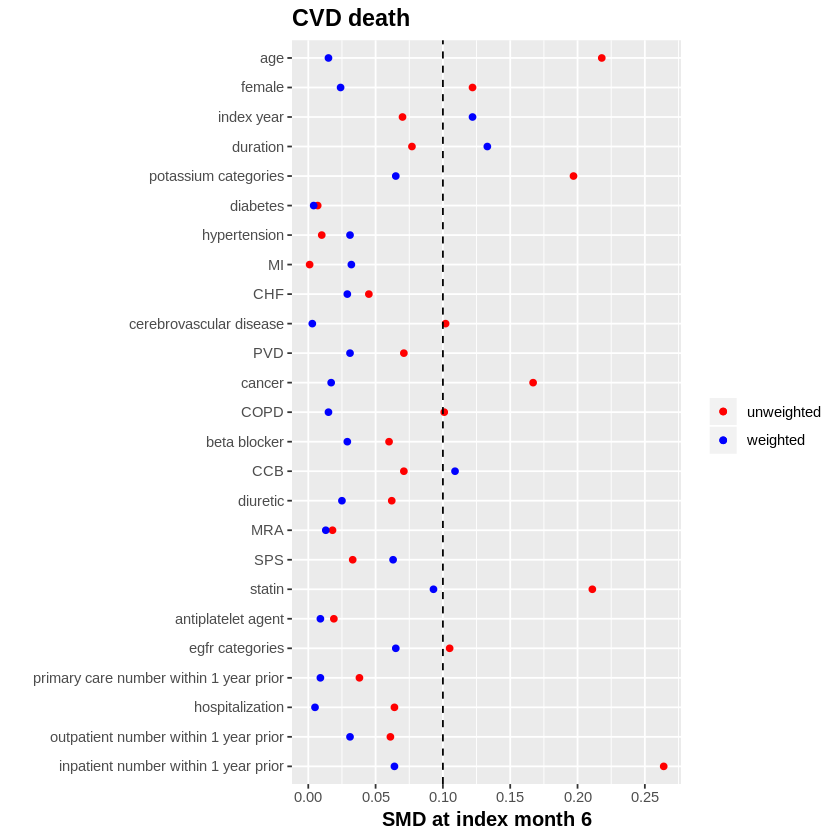

In [26]:
ggplot(data = tb1_SMD_summary, aes(x = SMD, y = covariates)) + 
    geom_point(aes(color = 'unweighted')) + 
    geom_point(aes(x = SMD.1, y = covariates, color = 'weighted')) + 
    scale_x_continuous(breaks = seq(0, 0.3, by = 0.05)) + 
    labs(title = 'CVD death', x = 'SMD at index month 6', y = '') +   
    geom_vline(xintercept = 0.1, linetype = "dashed", color = "black") + 
    theme(plot.title = element_text(size = 14, face = "bold"), 
          axis.title = element_text(size = 12, face = "bold")) + 
    scale_colour_manual("", values = c("unweighted" = "red", "weighted" = "blue"))

In [27]:
tb1

,discontinuation,reinitiation,SMD,discontinuation,reinitiation,SMD
n,917,4264,,4248.08,4287.87,
age (mean (SD)),74.25 (13.10),71.37 (13.21),0.218,70.91 (13.91),71.12 (13.08),0.015
female = 1 (%),462 (50.4),1889 (44.3),0.122,1903.7 (44.8),1871.3 (43.6),0.024
index_year (%),,,0.070,,,0.122
2007,116 (12.6),450 (10.6),,554.1 (13.0),440.2 (10.3),
2008,203 (22.1),944 (22.1),,1019.9 (24.0),943.9 (22.0),
2009,248 (27.0),1155 (27.1),,1117.0 (26.3),1162.9 (27.1),
2010,223 (24.3),1104 (25.9),,984.3 (23.2),1162.2 (27.1),
2011,127 (13.8),611 (14.3),,572.8 (13.5),578.6 (13.5),
duration (median [IQR]),"6.00 [2.00, 18.00]","8.00 [2.00, 19.00]",0.077,"6.00 [2.00, 17.00]","8.00 [2.00, 19.00]",0.133


In [28]:
incid_num_weighted <- function(data = dta_clone_CVD_death_imp1, weights = 'ipw_uns_trunc') {
    dta <- data %>% mutate(weights = data[[weights]]) %>% 
        arrange(ID, index_date) %>% 
        group_by(ID) %>% 
        summarise(tstart = as.Date('1970-01-01'), 
                  tstop = as.Date('1970-01-01') + sum(weights) * 30, 
                  outcome_CVD_death = sum(outcome_CVD_death * weights), 
                  X = first(X)) %>% 
        ungroup() %>% 
        group_by(X) %>% 
        summarise(n = length(ID), 
                  median.followup = round(median(time_length(difftime(tstop, tstart), 'year')), 2), 
                  q25.followup = round(quantile(time_length(difftime(tstop, tstart), 'year'), 0.25), 2), 
                  q75.followup = round(quantile(time_length(difftime(tstop, tstart), 'year'), 0.75), 2), 
                  weighted_followup = paste0(median.followup, " [", q25.followup, "-", q75.followup, "]"), 
                  weighted_event = round(sum(outcome_CVD_death), 0), 
                  weighted_person_years = round(sum(time_length(difftime(tstop, tstart), 'year')), 2)) %>% 
        dplyr::select(c('X', 'n', 'weighted_followup', 'weighted_event', 'weighted_person_years'))
    return(dta)
} 
incid_num_weighted()

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



X,n,weighted_followup,weighted_event,weighted_person_years
<chr>,<int>,<chr>,<dbl>,<dbl>
discontinuation,5669,0.13 [0-0.47],793,11524.88
reinitiation,5669,0.66 [0.45-1.81],279,10613.57


## causal effect estimation

In [29]:
dta_clone_CVD_death_imp1 <- dta_clone_CVD_death_imp1 %>% mutate(X = ifelse(X == 'reinitiation', 0, 1))

In [30]:
causal_effect_estimation <- function(data = dta_clone_CVD_death_imp1, weights = 'ipw', 
                                     xvar = c('age', 'female', 'index_year', 'duration', 'potassium_value',
                                              'primary_care_num', 'outpatient_num', 'inpatient_num', 
                                              'cov_diabetes_t0', 'cov_hypertension_t0', 
                                              'cov_MI_t0', 'cov_CHF_t0', 'cov_cerebrovascular_disease_t0', 'cov_PVD_t0', 
                                              'cov_cancer_t0', 'cov_COPD_t0', 
                                              'cov_beta_blocker_t0', 'cov_CCB_t0', 'cov_diuretic_t0', 'cov_MRA_t0', 'cov_SPS_t0', 
                                              'cov_statin_t0', 
                                              'cov_antiplatelet_agent_t0', 
                                              'cov_egfr_t0', 
                                              'cov_hospitalization_t0')) {
    regression_formula <- as.formula(ifelse(length(xvar) == 0, 'outcome_CVD_death ~ X + rms::rcs(rank, 3)', 
                                            paste('outcome_CVD_death ~ X + rms::rcs(rank, 3) +', 
                                                  paste(xvar, collapse = ' + '), sep = ' ')))
    regression_formula_int <- as.formula(ifelse(length(xvar) == 0, 'outcome_CVD_death ~ X * rms::rcs(rank, 3)', 
                                                paste('outcome_CVD_death ~ X * rms::rcs(rank, 3) +', 
                                                      paste(xvar, collapse = ' + '), sep = ' ')))
    CVD_death.logistic.adjusted <- parglm(regression_formula, 
                                      weights = data[[weights]], 
                                      data = data, 
                                      family = binomial(link = "logit"), 
                                      control = parglm.control(nthreads = 6))
    CVD_death.logistic.adjusted_int <- parglm(regression_formula_int, 
                                          weights = data[[weights]], 
                                          data = data, 
                                          family = binomial(link = "logit"), 
                                          control = parglm.control(nthreads = 6)) 
    CVD_death.res.adjusted <- summary(CVD_death.logistic.adjusted)
    n_month = 60 
    CVD_death_risk_summary_discontinuation <- data %>% 
        filter(rank == 1) %>% 
        mutate(X = 1) %>% 
        dplyr::select(c('ID', 'X', 'rank', xvar)) %>% 
        slice(rep(row_number(), n_month)) %>% 
        arrange(ID) %>% 
        group_by(ID) %>% 
        mutate(rank = cumsum(rank)) %>% 
        ungroup()
    CVD_death_risk_summary_discontinuation$p_CVD_death = predict(CVD_death.logistic.adjusted_int, 
                                                         CVD_death_risk_summary_discontinuation, 
                                                         type = 'response')
    CVD_death_risk_summary_discontinuation <- CVD_death_risk_summary_discontinuation %>%
        mutate(p_surv = 1 - p_CVD_death) %>% 
        group_by(ID) %>% 
        mutate(p_cumsurv = cumprod(p_surv), 
               p_cumCVD_death = 1 - p_cumsurv) %>% 
        ungroup() %>% 
        group_by(rank) %>% 
        summarise(p_cumsurv = mean(p_cumsurv), 
                  p_cumCVD_death = mean(p_cumCVD_death)) %>% 
        mutate(X = 'discontinuation')
    CVD_death_risk_summary_reinitiation <- data %>% 
        filter(rank == 1) %>% 
        mutate(X = 0) %>% 
        dplyr::select(c('ID', 'X', 'rank', xvar)) %>% 
        slice(rep(row_number(), n_month)) %>% 
        arrange(ID) %>% 
        group_by(ID) %>% 
        mutate(rank = cumsum(rank)) %>% 
        ungroup()
    CVD_death_risk_summary_reinitiation$p_CVD_death = predict(CVD_death.logistic.adjusted_int, 
                                                      CVD_death_risk_summary_reinitiation, 
                                                      type = 'response')
    CVD_death_risk_summary_reinitiation <- CVD_death_risk_summary_reinitiation %>%
        mutate(p_surv = 1 - p_CVD_death) %>% 
        group_by(ID) %>% 
        mutate(p_cumsurv = cumprod(p_surv), 
               p_cumCVD_death = 1 - p_cumsurv) %>% 
        ungroup() %>% 
        group_by(rank) %>% 
        summarise(p_cumsurv = mean(p_cumsurv), 
                  p_cumCVD_death = mean(p_cumCVD_death)) %>% 
        mutate(X = 'reinitiation')
    CVD_death_risk_summary <- rbind(CVD_death_risk_summary_discontinuation, CVD_death_risk_summary_reinitiation)
    risk_discontinuation_3_y <- CVD_death_risk_summary_discontinuation %>% 
        filter(rank == 36) %>% 
        dplyr::select(p_cumCVD_death) %>% as.numeric()
    risk_reinitiation_3_y <- CVD_death_risk_summary_reinitiation %>% 
        filter(rank == 36) %>% 
        dplyr::select(p_cumCVD_death) %>% as.numeric()
    RD <- (risk_discontinuation_3_y - risk_reinitiation_3_y) * 100
    RR <- (risk_discontinuation_3_y / risk_reinitiation_3_y)
    risk_res <- round(c(risk_discontinuation_3_y * 100, risk_reinitiation_3_y * 100, RD, RR, 
                        exp(CVD_death.res.adjusted$coefficients[2, 1])), 2)
    names(risk_res) <- c('3 year risk for discontinuation (%)', 
                         '3 year risk for reinitiation (%)', 
                         'risk difference (%)', 
                         'risk ratio', 
                         'hazard ratio')
    risk_res <- risk_res %>% t()
    risk_res <- list(risk_res, CVD_death_risk_summary)
    return(risk_res)
}

In [31]:
main_res = causal_effect_estimation(data = dta_clone_CVD_death_imp1, weights = 'ipw_uns_trunc', 
                                    xvar = c('index_year', 'duration'))
main_point_estimation <- main_res[[1]]
main_cum_incidence <- main_res[[2]]

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(xvar)` instead of `xvar` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [32]:
main_point_estimation

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
11.33,4.3,7.03,2.63,2.87


In [33]:
data_sample_generation <- function(k = 1, data = dta_clone_CVD_death_imp1) {
    set.seed(k)
    data_discontinuation <- data %>% filter(X == 1)
    ID_random_sample_discontinuation <- sample(unique(data_discontinuation$ID), 
                                               size = length(unique(data_discontinuation$ID)), 
                                               replace = T) 
    ID_random_sample_reinitiation <- ID_random_sample_discontinuation + length(ID_random_sample_discontinuation)
    ID_random_sample <- c(ID_random_sample_discontinuation, ID_random_sample_reinitiation)
    sub_data <- function(i, j = 1) {
        dta <- data %>% filter(ID == i) %>% mutate(ID = j) %>% data.frame()
        return(dta)
    }
    dataset_random_sample <- rbindlist(mapply(sub_data, ID_random_sample,  1 : length(ID_random_sample), SIMPLIFY = F))
    return(dataset_random_sample)
}

In [34]:
bootstrap_sub <- function (data = dta_clone_CVD_death_imp1, weights = 'ipw_uns_trunc', 
    xvar_boot = c('duration', 'index_year'), k = 1) {
    no_of_sample = 50
    CI_res_sub <- mclapply ((1 + (k - 1) * no_of_sample) : (k * no_of_sample), function(j) {
        dataset_random_sample <- data_sample_generation(j, data = data)
        Sys.sleep((j - (k - 1) * no_of_sample) * 5)
        causal_effect_estimation(data = dataset_random_sample, weights = weights, 
                                 xvar = xvar_boot)}, mc.cores = 50)   
    CI_res_sub <- foreach (i = 1 : no_of_sample, .combine = c) %do% {
        CI_res_sub[[i]]
    }
    return(CI_res_sub)
}

In [35]:
CI_res <- foreach (i = 1 : 10, .combine = c) %do% {
    bootstrap_sub(k = i)
}

In [36]:
no_of_sample = 500
CI_point_estimation <- foreach (i = seq(1, 2 * no_of_sample, 2), .combine = rbind) %do% {
    CI_res[[i]]
}
CI_point_estimation <- CI_point_estimation %>% data.frame()
colnames(CI_point_estimation) <- c('risk_dis', 'risk_re', 'RD', 'RR', 'HR')
CI_point_estimation <- CI_point_estimation %>% 
    summarise(lci_risk_dis = quantile(risk_dis, 0.025), 
              uci_risk_dis = quantile(risk_dis, 0.975), 
              lci_risk_re = quantile(risk_re, 0.025), 
              uci_risk_re = quantile(risk_re, 0.975), 
              lci_RD = quantile(RD, 0.025), 
              uci_RD = quantile(RD, 0.975), 
              lci_RR = quantile(RR, 0.025), 
              uci_RR = quantile(RR, 0.975), 
              lci_HR = quantile(HR, 0.025), 
              uci_HR = quantile(HR, 0.975))
CI_point_estimation <- round(matrix(as.numeric(CI_point_estimation), nrow = 5, ncol = 2, byrow = T), 2)
causal_effect_point_estimation <- paste(t(main_point_estimation), 
                                        ' (', CI_point_estimation[ , 1], '-', 
                                        CI_point_estimation[ , 2], ')', sep = '')
names(causal_effect_point_estimation) <- colnames(main_point_estimation)
main_res <- t(causal_effect_point_estimation)
main_res

3 year risk for discontinuation (%),3 year risk for reinitiation (%),risk difference (%),risk ratio,hazard ratio
11.33 (8.95-15.55),4.3 (3.74-4.94),7.03 (4.49-11.18),2.63 (1.98-3.72),2.87 (2.31-3.57)


In [37]:
CI_cum_incidence <- foreach (i = seq(2, 2 * no_of_sample, 2), .combine = cbind) %do% {
    CI_res[[i]]
}
CI_cum_incidence <- CI_cum_incidence[ , c(c(1, 4), seq(3, no_of_sample * 4, 4))]

In [38]:
CI_cum_incidence <- CI_cum_incidence %>% 
    gather(i, p_cumCVD_death, p_cumCVD_death : p_cumCVD_death.499, factor_key = TRUE) %>% ## Note!!!!
    arrange(rank, X) %>% 
    group_by(rank, X) %>% 
    summarise(lci_p_cumCVD_death = quantile(p_cumCVD_death, 0.025), 
              uci_p_cumCVD_death = quantile(p_cumCVD_death, 0.975))

`summarise()` regrouping output by 'rank' (override with `.groups` argument)



In [39]:
main_cum_incidence <- rbind(data.frame(rank = 0, p_cumsurv = 1, p_cumCVD_death = 0, X = 'discontinuation'), 
                            data.frame(rank = 0, p_cumsurv = 1, p_cumCVD_death = 0, X = 'reinitiation'), 
                            data.frame(main_cum_incidence))

In [40]:
CI_cum_incidence <- rbind(data.frame(rank = 0, X = 'discontinuation', lci_p_cumCVD_death = 0, uci_p_cumCVD_death = 0), 
                          data.frame(rank = 0, X = 'reinitiation', lci_p_cumCVD_death = 0, uci_p_cumCVD_death = 0), 
                          data.frame(CI_cum_incidence))

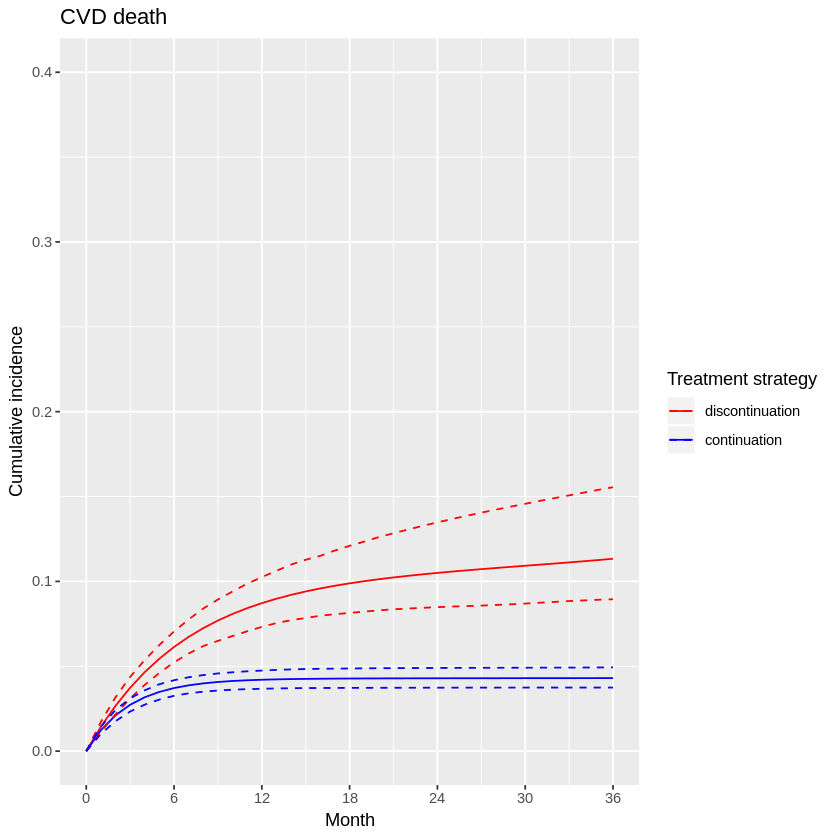

In [41]:
ggplot(data = main_cum_incidence %>% filter(rank <= 36), aes(x = rank, y = p_cumCVD_death, group = X, colour = X)) + 
    geom_line() + 
    geom_line(data = CI_cum_incidence %>% filter(rank <= 36), aes(x = rank, y = lci_p_cumCVD_death, group = X, colour = X), 
              linetype = "dashed") + 
    geom_line(data = CI_cum_incidence %>% filter(rank <= 36), aes(x = rank, y = uci_p_cumCVD_death, group = X, colour = X), 
              linetype = "dashed") + 
    xlab('Month') + 
    ylab('Cumulative incidence') + 
    scale_x_continuous(breaks = seq(0, 36, 6)) + 
    ylim(0, 0.4) +
    labs(title = 'CVD death', color = "Treatment strategy") + 
    scale_color_manual(labels=c("discontinuation", "continuation"),
                       values=c("red", "blue"))

## Sensitivity analyses

### <font face = "Times New Roman" color='blue'>stabilized IPWs without truncation</font>

### <font face = "Times New Roman" color='blue'>stabilized IPWs by ML</font>

### <font face = "Times New Roman" color='blue'>albuminuria included as a time-varying confounder</font>

## subgroup analysis

In [44]:
### by sex
sub_res_sex <- subgroup_analysis(by = 'female')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

